## What is a Pipeline in Scikit-Learn & Why is it important?

Let's say you want to build a machine learning model to predict the quality of a red wine. A common workflow for solving this task would be as follows.

In [1]:
# import libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error

# for code formating
%load_ext nb_black

# read the data and split it into a training and test set
url = "http://bit.ly/wine-quality-lwd"
wine = pd.read_csv(url)
X = wine.drop("quality", axis=1).copy()
y = wine["quality"].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

<IPython.core.display.Javascript object>

Here, first we read the data and split it into a training and a test set. Once we did that we need to prepare the data for machine learning before building the model like filling the missing value, scaling the data, one hot encoding categorical features etc. 

In [2]:
# fill missing values with medians
imputer = SimpleImputer(strategy="median")
X_train_tr = imputer.fit_transform(X_train)
# scale the data
scale = StandardScaler()
X_train_tr = scale.fit_transform(X_train_tr)

# do the same for test data. But here we will not apply the
# fit method only the transform method because we
# do not want our model to learn anything from the test data
X_test_tr = imputer.transform(X_test)
X_test_tr = scale.transform(X_test_tr)

<IPython.core.display.Javascript object>

Once we prepare the data, we can go forward and train the model on the training data and make predictions on the test
data. 

In [3]:
from sklearn.neighbors import KNeighborsRegressor

# initiate the k-nearest neighbors regressor class
knn = KNeighborsRegressor()
# train the knn model on training data
knn.fit(X_train_tr, y_train)
# make predictions on test data
y_pred = knn.predict(X_test_tr)
# measure the performance of the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

0.6729908369856655


<IPython.core.display.Javascript object>

As you can see there are lots of steps that need to be executed in the right order for training the model and If you mess things up, your model will be complete garbage. And this is just a simple example of a ml workflow. As you start working with more complicated model, the chances of making errors becomes much higher. This is where the pipeline comes in.

### What is a Pipeline?

A Pipeline is simply a method of chaining multiple steps together in which the output of the previous step is used as the input for the next step.

Let's see how can we build the same model using a pipeline assuming we already split the data into a training and a test set.


In [4]:
# list all the steps here for building the model
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler(), KNeighborsRegressor()
)
# apply all the transformation on the training set and train an knn model
pipe.fit(X_train, y_train)
# apply all the transformation on the test set and make predictions
y_pred = pipe.predict(X_test)
# measure the performance
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(rmse)

0.6729908369856655


<IPython.core.display.Javascript object>

That's it. Every steps of the model from start to finish is defined in a single step and Scikit-Learn did everything for you. First it applied all the appropriate data transformation on the training set, build the model on it when you call the fit method and then transform the test set and made the prediction when you call the predict method.

Isn't this simple and nice? Pipeline helps you encapsulated complexity just like functions do. It also helps you avoid leaking information from your test data into the trained model during cross-validation which we will see later in this post. It is easier use and debug. If you don't like something you can easily replace that step with something else without making too much changes to your code. It is also nicer for other to read and understand your code. 

Now, let's see this in more details.

## How to Use a Pipeline in Scikit-Learn?

The Pipeline in scikit-learn is built using a list of (`key, value`) pairs where the `key` is a string containing the name you want to give to a particular step and `value` is an estimator object for that step.

In [5]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor

pipe_long = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
        ("knn", KNeighborsRegressor()),
    ]
)
pipe_long

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])

<IPython.core.display.Javascript object>

There is also a shorthand syntax(`make_pipeline`) for making a pipeline that we saw earlier. It only takes the estimators and fill in the names automatically with the lowercase class names.

In [6]:
from sklearn.pipeline import make_pipeline

pipe_short = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler(), KNeighborsRegressor()
)
pipe_short

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('kneighborsregressor', KNeighborsRegressor())])

<IPython.core.display.Javascript object>

#### Rules for creating a Pipeline - 

There are few rules that you need to follow when creating a Pipeline in scikit Learn.
1. All estimators in a pipeline, except the last one, must be transformers (i.e. must have a [transform](https://scikit-learn.org/stable/glossary.html#term-transform) method). The last estimator may be any type (transformer, classifier, etc.).
2. Names for the steps can be anything you like as long as they are unique and don't contains double underscores as they are used during hyperparameter tunning.

## Accessing Steps of a Pipeline

The estimators of a pipeline are stored as a list in the steps attribute and can be accessed by index or by their name like this.

In [7]:
print(pipe_long.steps[0])
print(pipe_long.steps[1])

('imputer', SimpleImputer(strategy='median'))
('scaler', StandardScaler())


<IPython.core.display.Javascript object>

In [8]:
print(pipe_long[2])

KNeighborsRegressor()


<IPython.core.display.Javascript object>

In [9]:
print(pipe_long["imputer"])

SimpleImputer(strategy='median')


<IPython.core.display.Javascript object>

Pipeline’s `named_steps` attribute allows accessing steps by name with tab completion in interactive environments

In [10]:
print(pipe_long.named_steps.imputer)

SimpleImputer(strategy='median')


<IPython.core.display.Javascript object>

You can also use the slice notation to access them.

In [11]:
print(pipe_long[1:])

Pipeline(steps=[('scaler', StandardScaler()), ('knn', KNeighborsRegressor())])


<IPython.core.display.Javascript object>

## Grid Search using a Pipeline

You can also do grid search for hyperparameter optimization with a pipeline. And to access the parameters of the estimators in the pipeline use the `<estimator>__<parameter>` syntax. 

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

# create a pipeline
pipe = make_pipeline(
    SimpleImputer(strategy="median"), StandardScaler(), KNeighborsRegressor()
)
# list of parameter values to try
param_grid = {
    "kneighborsregressor__n_neighbors": [3, 5, 8, 12, 15],
    "kneighborsregressor__weights": ["uniform", "distance"],
}
grid = GridSearchCV(pipe, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('simpleimputer',
                                        SimpleImputer(strategy='median')),
                                       ('standardscaler', StandardScaler()),
                                       ('kneighborsregressor',
                                        KNeighborsRegressor())]),
             param_grid={'kneighborsregressor__n_neighbors': [3, 5, 8, 12, 15],
                         'kneighborsregressor__weights': ['uniform',
                                                          'distance']},
             scoring='neg_mean_squared_error')

<IPython.core.display.Javascript object>

In [13]:
# best score after grid search
print(np.sqrt(-grid.best_score_))

0.6187124991308474


<IPython.core.display.Javascript object>

In [14]:
print(grid.best_estimator_)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('kneighborsregressor',
                 KNeighborsRegressor(n_neighbors=15, weights='distance'))])


<IPython.core.display.Javascript object>

In [15]:
# the estimators can be accessed like this
print(grid.best_estimator_.named_steps.kneighborsregressor)
print(grid.best_estimator_["kneighborsregressor"])

KNeighborsRegressor(n_neighbors=15, weights='distance')
KNeighborsRegressor(n_neighbors=15, weights='distance')


<IPython.core.display.Javascript object>

In [16]:
# and to access the nested parameters of the estimators
print(grid.best_estimator_.named_steps.kneighborsregressor.n_neighbors)
print(grid.best_estimator_["kneighborsregressor"].n_neighbors)

15
15


<IPython.core.display.Javascript object>

### For people, who wants to go one step further.

So far, we only worked with a single algorithm(K-Neasrest Neighbors) but there are many other algorithms that might perform better than this.So, now let's try different algorithms and see which perform best and we will also try 
different options for preparing the data that goes well with a particular algorithm, everything in a single step.

In [17]:
# install XGBBoost if not
!pip install xgboost
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

# pipeline for the model
pipe = Pipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("regressor", RandomForestRegressor()),
    ]
)

# model tunning with GridSearch
param_grid = {
    "imputer__strategy": ["mean", "median", "most_frequent", "constant"],
    "scaler": [StandardScaler(), MinMaxScaler(), "passthrough"],
    "regressor": [
        KNeighborsRegressor(),
        LinearRegression(),
        RandomForestRegressor(random_state=42),
        DecisionTreeRegressor(random_state=42),
        XGBRegressor(random_state=42),
    ],
}


grid = GridSearchCV(
    pipe,
    param_grid=param_grid,
    cv=5,
    scoring="neg_mean_squared_error",
    return_train_score=True,
)

grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('regressor', RandomForestRegressor())]),
             param_grid={'imputer__strategy': ['mean', 'median',
                                               'most_frequent', 'constant'],
                         'regressor': [KNeighborsRegressor(),
                                       LinearRegression(),
                                       RandomForestRegressor(random_state=42),
                                       DecisionTreeRegressor(random_state=42),
                                       X...
                                                    min_child_weight=None,
                                                    missing=nan,
                                                    monotone_constraints=None,
                                                    n_estimators=100,
        

<IPython.core.display.Javascript object>

In [18]:
print(np.sqrt(-grid.best_score_))

0.6076141317775702


<IPython.core.display.Javascript object>

In [19]:
print(grid.best_estimator_)
print(grid.best_estimator_.named_steps.imputer.strategy)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', 'passthrough'),
                ('regressor', RandomForestRegressor(random_state=42))])
mean


<IPython.core.display.Javascript object>

In [20]:
result = pd.DataFrame(grid.cv_results_)

<IPython.core.display.Javascript object>

Here, we tried 5 different algorithms with default values and we also tested the scaler and imputer method that works best with them. The best algorithm for this task is the RandomForestRegressor which is scaled and the mean is used to fill the missing values. Some other models that performed well are XGBRegressor and LinearRegression. 

### For those, who wants to go nuts with Pipelines

Now, we narrow down to few algorithms that are performing well on this dataset, we can further improve the result by tunning the parameters of these models separately with different settings. 

In [21]:
# make the pipeline and do grid search
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", StandardScaler()),
        ("regressor", RandomForestRegressor()),
    ]
)

param_grid = [
    {
        "regressor": [RandomForestRegressor(random_state=42)],
        "regressor__n_estimators": [100, 300, 500, 1000],
        "regressor__max_depth": [3, 5, 8, 15],
        "regressor__max_features": ["log2", "sqrt", "auto"],
    },
    {
        "regressor": [XGBRegressor(random_state=42)],
        "regressor__max_depth": [3, 5, 8, 15],
        "regressor__learning_rate": [0.1, 0.01, 0.05],
        "regressor__gamma": [0, 0.25, 1.0],
        "regressor__lambda": [0, 1.0, 10.0],
    },
]

grid = GridSearchCV(pipe, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                       ('scaler', StandardScaler()),
                                       ('regressor', RandomForestRegressor())]),
             param_grid=[{'regressor': [RandomForestRegressor(max_depth=15,
                                                              max_features='log2',
                                                              n_estimators=1000,
                                                              random_state=42)],
                          'regressor__max_depth': [3, 5, 8, 15],
                          'regressor__max_features': ['log2', 'sqrt', 'auto'],
                          'regressor...
                                                     n_jobs=None,
                                                     num_parallel_tree=None,
                                                     random_state=42,
                                            

<IPython.core.display.Javascript object>

In [22]:
print(grid.best_estimator_)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('regressor',
                 RandomForestRegressor(max_depth=15, max_features='log2',
                                       n_estimators=1000, random_state=42))])


<IPython.core.display.Javascript object>

In [23]:
print(np.sqrt(-grid.best_score_))

0.6026456255737074


<IPython.core.display.Javascript object>

## Feature Selections with pipelines

We can also do feature selection with a pipeline. There are various ways to do feature selection in scikit-Learn but
here I am going to show one of the method for doing it with a pipeline. Later, I might write more about it in the 
future posts so make sure to subscribe to the blog.

In [24]:
print(X_train.shape)

(1119, 11)


<IPython.core.display.Javascript object>

At this moment we have 11 features in this data set. Let's do feature selection to only select most important features.

In [25]:
# calculate the f_values and p_values for all the features
from sklearn.feature_selection import f_regression

f_values, p_values = f_regression(X_train, y_train)

<IPython.core.display.Javascript object>

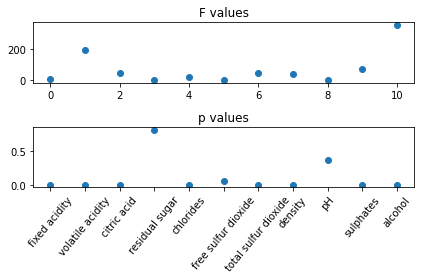

<IPython.core.display.Javascript object>

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 1)
ax[0].set_title("F values")
ax[0].plot(f_values, "o")
ax[1].set_title("p values")
ax[1].plot(p_values, "o")
# ax[1].set_yscale("log")

ax[1].set_xticks(range(X_train.shape[1]))
ax[1].set_xticklabels(X_train.columns, rotation=50)
fig.tight_layout()

In [27]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=list(range(X_train.shape[1])), y=p_values, mode="markers"))
fig.update_layout(
    title="Feature Selection",
    yaxis_title="P-Value",
    xaxis=dict(
        title="Features",
        tickmode="array",
        tickvals=list(range(X_train.shape[1])),
        ticktext=[col for col in X_train.columns],
    ),
)

fig.show()

<IPython.core.display.Javascript object>

If we look at the result based on p-values we can see that out of 11 features 10 are highly important. They all have p-value less than 0.5 except the residual sugar feature whose p-value > 0.5. So, let only select 10 features for the 
model.

In [28]:
# way to access the random forest model
print(grid.best_estimator_.named_steps.regressor)

RandomForestRegressor(max_depth=15, max_features='log2', n_estimators=1000,
                      random_state=42)


<IPython.core.display.Javascript object>

In [29]:
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import cross_val_score

# pipeline for feature selection
pipe_sel = make_pipeline(
    SimpleImputer(strategy="mean"),
    StandardScaler(),
    SelectKBest(k=10, score_func=f_regression),
    grid.best_estimator_.named_steps.regressor,
)

scores = cross_val_score(
    pipe_sel, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
)
# mean rmse
print(np.mean(np.sqrt(-scores)))

0.6009272993149999


<IPython.core.display.Javascript object>

## ColumnTransformer with Pipelines

So far, we only worked with numerical data to keep things simple but this is not going to be the case always. You also
going to some categorical data like sex(Male,Female), color(Red, Blue, Green) etc and as these columns are categorical
we can't apply the same transformation that we applied with numerical columns like calcualting the mean or median of 
male and female. We need to do one-hot encoding for this feature. 

One of the easiest way we can to apply different transformation to numerical and categorical columns in scikit-learn is by using the columnTransformer.  

We will read a new data set which has mixed data type(numerical and categorical) and see how to apply everything that we have learned so far using a pipeline. 

In [30]:
import pandas as pd
import numpy as np

# read the happiness data
url = "http://bit.ly/happiness-2019"
happiness = pd.read_csv(url)
happiness.head()

,Overall rank,Country or region,Score,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption
0,1,Finland,7.769,1.340,1.587,0.986,0.596,0.153,0.393
1,2,Denmark,7.600,1.383,1.573,0.996,0.592,0.252,0.410
2,3,Norway,7.554,1.488,1.582,1.028,0.603,0.271,0.341
3,4,Iceland,7.494,1.380,1.624,1.026,0.591,0.354,0.118
4,5,Netherlands,7.488,1.396,1.522,0.999,0.557,0.322,0.298


<IPython.core.display.Javascript object>

In [31]:
happiness.dtypes

Overall rank                      int64
Country or region                object
Score                           float64
GDP per capita                  float64
Social support                  float64
Healthy life expectancy         float64
Freedom to make life choices    float64
Generosity                      float64
Perceptions of corruption       float64
dtype: object

<IPython.core.display.Javascript object>

In [32]:
happiness.isnull().sum()

Overall rank                    0
Country or region               0
Score                           0
GDP per capita                  0
Social support                  0
Healthy life expectancy         0
Freedom to make life choices    0
Generosity                      0
Perceptions of corruption       0
dtype: int64

<IPython.core.display.Javascript object>

So, everything looks good. All the columns are numerical except the Country column as we expected. And there is also
no null values but we will still use simple imputer to fill the missing values because we can't be sure that the 
future data will not have null values if we decided to deploy this model. 

In [33]:
# create a training and a test set
X = happiness.drop(["Overall rank", "Score"], axis=1).copy()
y = happiness["Score"].copy()
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

<IPython.core.display.Javascript object>

Build separate pipielines for numerical and categorical data and combine them using columnTransformer that apply appropriate transfomation based on the column data type.

In [34]:
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# first select the numerical and categorical columns
cat_cols = X_train.select_dtypes(include=["object"]).columns.tolist()
num_cols = X_train.select_dtypes(exclude=["object"]).columns.tolist()

# pipeline for categorical data
cat_preprocessing = make_pipeline(
    SimpleImputer(strategy="constant", fill_value="NA"),
    OneHotEncoder(handle_unknown="ignore", sparse=False),
)

# pipeline for numerical data
num_preprocessing = make_pipeline(SimpleImputer(strategy="mean"), StandardScaler())

# combine both pipeline using a columnTransformer
preprocessing = ColumnTransformer(
    [("num", num_preprocessing, num_cols), ("cat", cat_preprocessing, cat_cols)]
)

preprocessing

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['GDP per capita', 'Social support',
                                  'Healthy life expectancy',
                                  'Freedom to make life choices', 'Generosity',
                                  'Perceptions of corruption']),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(hand

<IPython.core.display.Javascript object>

The ColumnTransformer requires a list of tuples where each tuple contains a name, a transformer and a list of names(or indices) of columns that the tarnsfomer should be applied to. 

In [35]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

# make a new pipeline that does everything
full_pipe = Pipeline(
    [
        ("preprocess", preprocessing),
        ("regressor", RandomForestRegressor(random_state=42)),
    ]
)

# measure model performance using cross-validation
scores = cross_val_score(
    full_pipe, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
)
# rmse
print(np.mean(np.sqrt(-scores)))

0.4799916219726474


<IPython.core.display.Javascript object>

So, here is it. We created a pipeline that encapsulate every step of the process that needs to be done in order to 
create the ml model. Isn't this awesome. Nice and simple. 

we can also do grid search as before.

In [36]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    "preprocess__num__simpleimputer__strategy": ["mean", "median", "constant"],
    "regressor__n_estimators": [100, 300, 500],
    "regressor__max_depth": [1, 3, 5, 8],
}

grid = GridSearchCV(
    full_pipe, param_grid=param_grid, scoring="neg_mean_squared_error", cv=5
)
grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer()),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         ['GDP '
                                                                          'per '
                                                                          'capita',
                                                                          'Social '
                                                                          'support'

<IPython.core.display.Javascript object>

In [37]:
# rmse
print(np.sqrt(-grid.best_score_))

# To access the estimator
print(grid.best_estimator_.named_steps.regressor)

0.4810408003003286
RandomForestRegressor(max_depth=8, n_estimators=300, random_state=42)


<IPython.core.display.Javascript object>

In [38]:
# To access the transformers
# print(grid.best_estimator_.named_steps.preprocess.transformers_[0])
# print(grid.best_estimator_.named_steps.preprocess.transformers_[1])

<IPython.core.display.Javascript object>

In [39]:
# best hyperparameters
print(grid.best_params_)

{'preprocess__num__simpleimputer__strategy': 'mean', 'regressor__max_depth': 8, 'regressor__n_estimators': 300}


<IPython.core.display.Javascript object>

And we are done. We created a model from scratch and did everything using a pipeline.

## What to do next 

One of the best way to understand something is to do it yourself. Find a dataset that you like and create a single 
pipeline that does full data preparation, model selection and prediction. Apply everything that you learned in this post. 

I hope you find this post helpful. If you do, then please subscribe to our blog. And also share this post with others. Sharing is caring. And if you have any questions that feel free to ask in the comment section below. 